In [111]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hasanmoni","key":"1ef5ad18264beff7f45566f8175b8c03"}'}

In [112]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


### Loading necessary library

In [113]:
import cv2, math, ast, os
import numpy as np 
import pandas as pd 


import matplotlib.pyplot as plt
import matplotlib.patches as patches

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.utils import shuffle

tqdm.pandas()


### Path of the file

In [114]:
path = "/content/drive/My Drive/Global Weight EDA/global-wheat-detection"
dataset_img_train = "/content/drive/My Drive/Global Weight EDA/global-wheat-detection/train"
dataset_img_test = "/content/drive/My Drive/Global Weight EDA/global-wheat-detection/test"


In [115]:
# Train csv file
train_df = pd.read_csv(os.path.join(path, "train.csv"))
train_df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [116]:
# Shape of the file
print("Shape of the train_df :", train_df.shape)

Shape of the train_df : (147793, 5)


### Reading some unique images

In [117]:
# Reading 1000 unique images
uni_image = train_df['image_id'].unique()
uni_image_1000 = uni_image[:1000]
print(len(uni_image_1000))


uni_img_df = pd.DataFrame(uni_image_1000, index=[i for i in range(1,1001)]).rename(columns={0:'image_id'})
uni_img_df.head()

1000


image_id
1  b6ab77fd7
2  b53afdf5c
3  7b72ea0fb
4  91c9d9c38
5  41c0123cc

In [118]:
# Reading 500 unique images
%time
sample_len = 500
def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(os.path.join(dataset_img_train, file_path))
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_image = train_df["image_id"][:sample_len].progress_apply(load_image)


  1%|          | 6/500 [00:00<00:09, 53.96it/s]

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


100%|██████████| 500/500 [00:12<00:00, 40.25it/s]


### Details of the images

In [119]:
print("Total number of images are :", train_df.shape[0])
print("Total number of unique images are :", train_df["image_id"].nunique())
print("Dimension of the images are :", train_df['height'].nunique, train_df['width'].nunique)
print("Maximum number of wheat head in the image are :", max(train_df["image_id"].value_counts()))
print("Average wheat head in the images :", len(train_df)/train_df["image_id"].nunique())


Total number of images are : 147793
Total number of unique images are : 3373
Dimension of the images are : <bound method IndexOpsMixin.nunique of 0         1024
1         1024
2         1024
3         1024
4         1024
          ... 
147788    1024
147789    1024
147790    1024
147791    1024
147792    1024
Name: height, Length: 147793, dtype: int64> <bound method IndexOpsMixin.nunique of 0         1024
1         1024
2         1024
3         1024
4         1024
          ... 
147788    1024
147789    1024
147790    1024
147791    1024
147792    1024
Name: width, Length: 147793, dtype: int64>
Maximum number of wheat head in the image are : 116
Average wheat head in the images : 43.8164838422769


### Distribution of images by wheat head

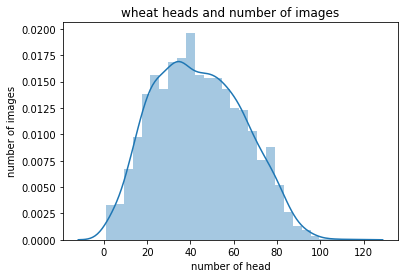

In [120]:
sns.distplot(train_df["image_id"].value_counts(), kde=True)
plt.xlabel("number of head")
plt.ylabel("number of images")
plt.title("wheat heads and number of images")
plt.show()


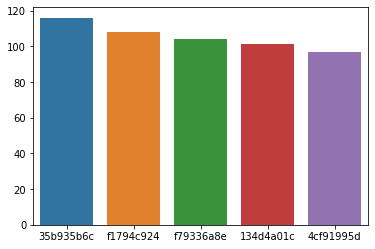

In [121]:
# most 5 wheat head images
wheat_head = train_df["image_id"].value_counts()
wheat_head_five = wheat_head[:5]
sns.barplot(x = wheat_head_five.index, y = wheat_head_five.values)

### Bounding boxes in every image

In [122]:
box_count = train_df["image_id"].value_counts()
hist_data = [box_count.values]
group_labels = ['Count'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size=2)
fig.update_layout(title_text="Number of bounding boxes per image", template="simple_white", title_x=0.5)
fig.show()


### Making new columns from bbox

In [123]:
train_df[['x_min','y_min', 'width', 'height']] = pd.DataFrame([ast.literal_eval(x) for x in train_df.bbox.tolist()], index= train_df.index)
train_df = train_df[['image_id', 'bbox', 'source', 'x_min', 'y_min', 'width', 'height']]
train_df.head()


image_id                         bbox   source  x_min  y_min  width  height
0  b6ab77fd7   [834.0, 222.0, 56.0, 36.0]  usask_1  834.0  222.0   56.0    36.0
1  b6ab77fd7  [226.0, 548.0, 130.0, 58.0]  usask_1  226.0  548.0  130.0    58.0
2  b6ab77fd7  [377.0, 504.0, 74.0, 160.0]  usask_1  377.0  504.0   74.0   160.0
3  b6ab77fd7  [834.0, 95.0, 109.0, 107.0]  usask_1  834.0   95.0  109.0   107.0
4  b6ab77fd7  [26.0, 144.0, 124.0, 117.0]  usask_1   26.0  144.0  124.0   117.0

### Visualize some images

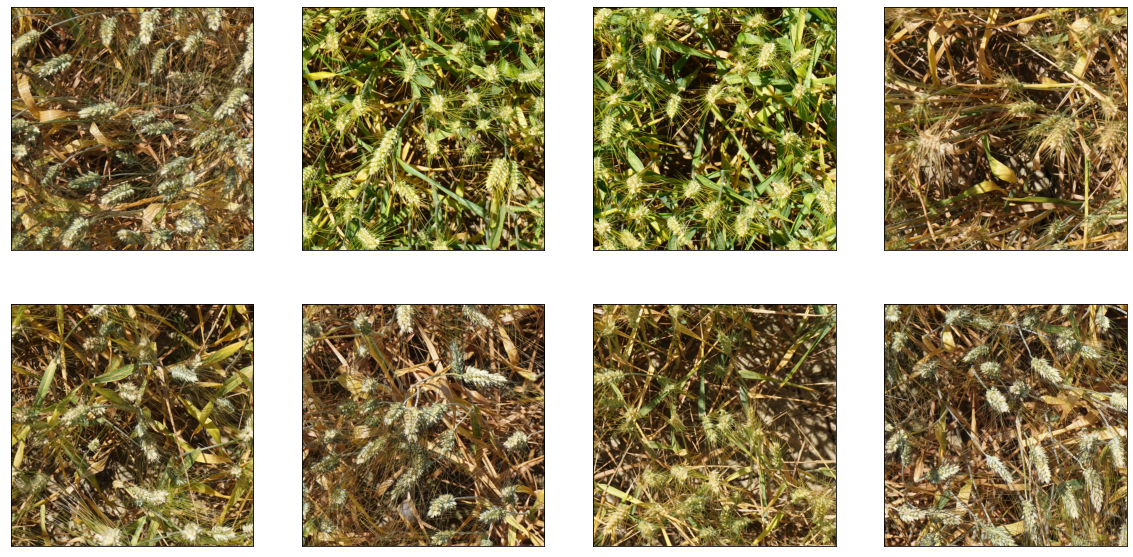

In [124]:
# Visualize few samples of current training dataset
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
count=1000
for row in ax:
    for col in row:
        img = plt.imread(f'{os.path.join(path, "train", train_df["image_id"].unique()[count])}.jpg')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        col.imshow(img)
        count += 1
plt.show()


### Visualize image with bbox

In [125]:
def get_bbox(image_id, df, col, color='white'):
    bboxes = df[df['image_id'] == image_id]
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (bboxes['x_min'].iloc[i], bboxes['y_min'].iloc[i]),
            bboxes['width'].iloc[i], 
            bboxes['height'].iloc[i], 
            linewidth=2, 
            edgecolor=color, 
            facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

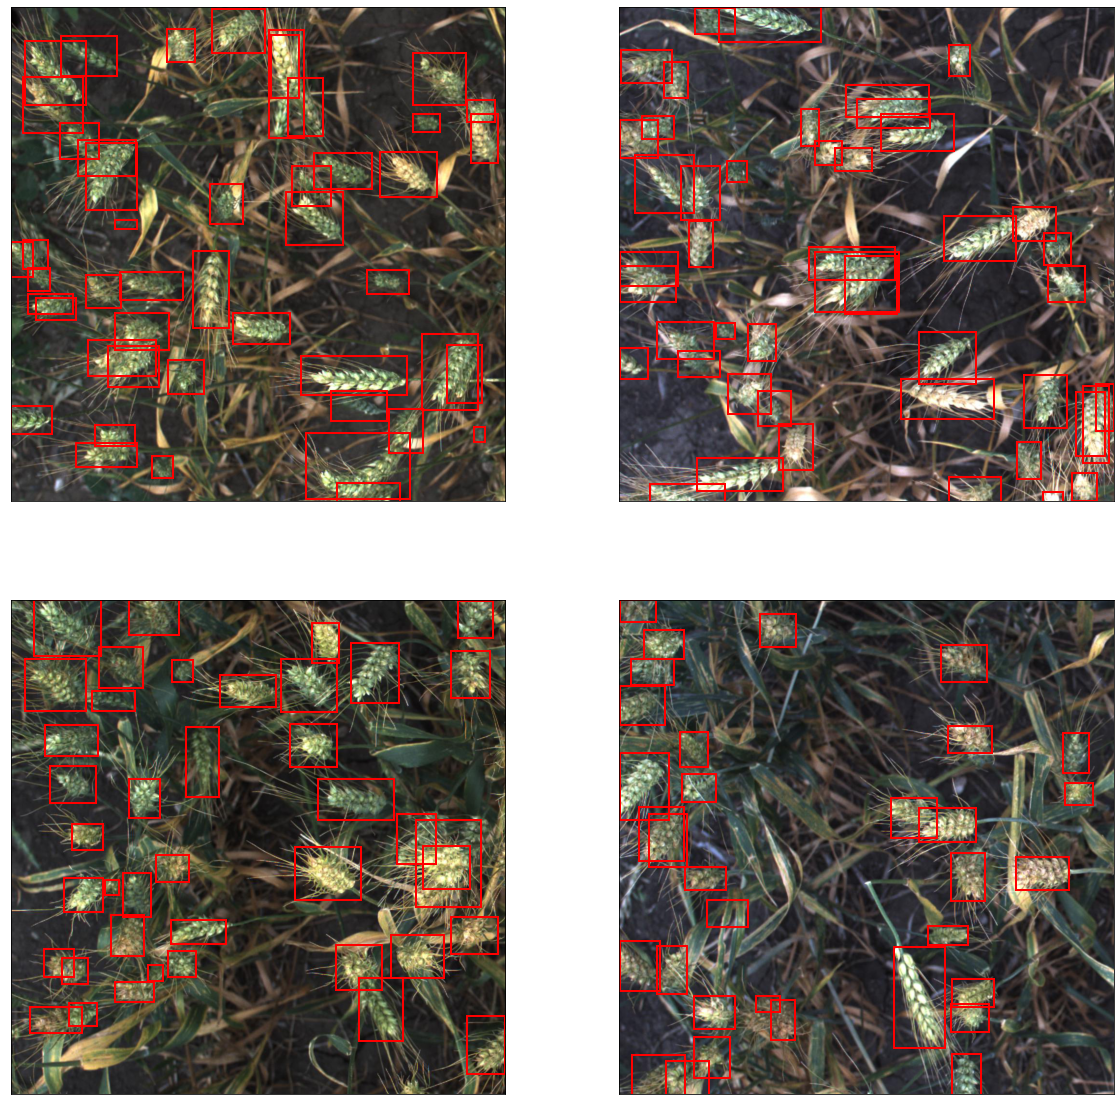

In [126]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
count=0
for row in ax:
    for col in row:
        img_id = train_df["image_id"].unique()[count]
        img = plt.imread(f'{os.path.join(path, "train", img_id)}.jpg')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        get_bbox(img_id, train_df, col, color='red')
        col.imshow(img)
        count += 1
plt.show()

### Image with maximum wheat head

Maximum wheat heads : 116


[]

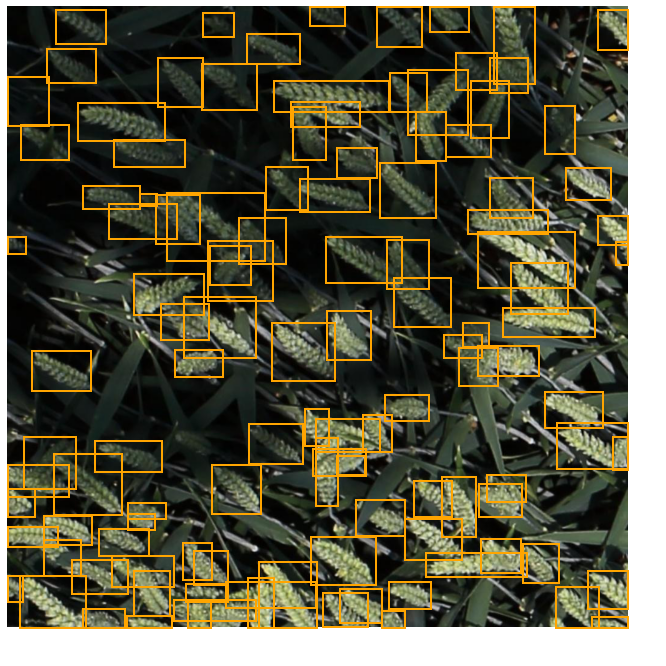

In [127]:
image_id = (train_df['image_id'].value_counts() == max(train_df["image_id"].value_counts())).index[0]
print('Maximum wheat heads :',max(train_df["image_id"].value_counts()))
img = plt.imread(f'{os.path.join(path, "train/", image_id)}.jpg')
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
get_bbox(image_id, train_df, ax, color='orange')
ax.imshow(img)
plt.plot()



### Wheat source

In [128]:
source = train_df['source'].value_counts()
train_df['source'].value_counts()

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

In [129]:
wheat_src_df = train_df.groupby(['source']).agg({'image_id':'count'}).reset_index()
wheat_src_df.rename(columns={'image_id':'count'},inplace=True)
wheat_src_df


source  count
0  arvalis_1  45716
1  arvalis_2   4179
2  arvalis_3  16665
3     ethz_1  51489
4    inrae_1   3701
5     rres_1  20236
6    usask_1   5807

In [130]:
# Pie chart 
fig = go.Figure(data=[
    go.Pie(labels=source.index, values=source.values)
])

fig.update_layout(title='Source distribution')
fig.show()

In [131]:
# bar chart
fig = go.Figure(go.Bar(x=train_df['source'].value_counts().index, 
                       y=train_df['source'].value_counts(),
                       marker_color='lightsalmon'))
fig.update_layout(title_text="Bar chart of sources", title_x=0.5)
fig.show()

### Bounding box count in the images

In [132]:
bbox_count = train_df.groupby("source")["image_id"].apply(lambda X: X.value_counts().mean()).reset_index().rename(columns={"image_id": "bbox_count"})

fig = go.Figure(go.Bar(x=bbox_count.source, 
                       y=bbox_count.bbox_count,
                       name='Bbox counts', marker_color='indianred'))
fig.update_layout(title_text="Bar chart of Bbox counts in image", template="simple_white", title_x=0.5)
fig.show()


### Channel Distribution

In [133]:
red_values = [np.mean(train_image[idx][:, :, 0]) for idx in range(len(train_image))]
green_values = [np.mean(train_image[idx][:, :, 1]) for idx in range(len(train_image))]
blue_values = [np.mean(train_image[idx][:, :, 2]) for idx in range(len(train_image))]
values = [np.mean(train_image[idx]) for idx in range(len(train_image))]


In [134]:
fig = ff.create_distplot([values], group_labels=["Channels"], colors=["purple"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

### Red Channel Values

In [135]:
fig = ff.create_distplot([red_values], group_labels=["R"], colors=["red"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of red channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig


### Blue Channel Values

In [136]:
fig = ff.create_distplot([blue_values], group_labels=["B"], colors=["blue"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of blue channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig


### Green Channel Values

In [137]:
fig = ff.create_distplot([green_values], group_labels=["G"], colors=["green"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of green channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig


### All the Channels togather

In [138]:
fig = go.Figure()

for idx, values in enumerate([red_values, green_values, blue_values]):
    if idx == 0:
        color = "Red"
    if idx == 1:
        color = "Green"
    if idx == 2:
        color = "Blue"
    fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color=color.lower())))
    
fig.update_layout(yaxis_title="Mean value", xaxis_title="Color channel",
                  title="Mean value vs. Color channel", template="plotly_white")


In [139]:
fig = ff.create_distplot([red_values, green_values, blue_values],
                         group_labels=["R", "G", "B"],
                         colors=["red", "green", "blue"])
fig.update_layout(title_text="Distribution of Red,Blue,Green channel values", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5
fig

### Lets Catagorise the Images based on on Wheat heads

In [140]:
df_img_wht_heads = train_df.groupby(['image_id']).agg({'source':'count'}).reset_index().rename(columns={'source':'wheat_head_cnt'})
df_img_wht_heads

image_id  wheat_head_cnt
0     00333207f              55
1     005b0d8bb              20
2     006a994f7              25
3     00764ad5d              41
4     00b5fefed              25
...         ...             ...
3368  ffb445410              57
3369  ffbf75e5b              52
3370  ffbfe7cc0              34
3371  ffc870198              41
3372  ffdf83e42              39

[3373 rows x 2 columns]

In [141]:
df_img_wht_heads.head()

image_id  wheat_head_cnt
0  00333207f              55
1  005b0d8bb              20
2  006a994f7              25
3  00764ad5d              41
4  00b5fefed              25

### Based on 5 point summary , let catagorise the data

In [142]:
df_img_wht_heads['wheat_head_cnt'].describe(include="all")


count    3373.000000
mean       43.816484
std        20.374820
min         1.000000
25%        28.000000
50%        43.000000
75%        59.000000
max       116.000000
Name: wheat_head_cnt, dtype: float64

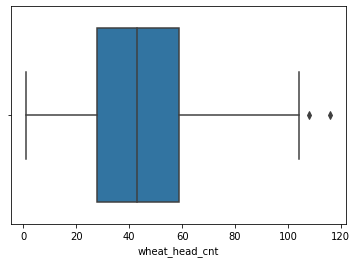

In [143]:
sns.boxplot(df_img_wht_heads['wheat_head_cnt'])

In [144]:
def catagory(col):
    if col >= 0 and col <= 28 :
        ctg="Less_Wheat_heads"
    elif col <= 43 and col >= 28:
        ctg="Medium_Wheat_heads"
    elif col <= 59 and col >= 43:
        ctg="High_Wheat_heads"
    else:
        ctg="Extra_High_Wheat_heads"
    return ctg

In [145]:
def binary_catagory(col):
    if col >= 0 and col <= 43 :
        ctg=0
    else:
        ctg=1
    return ctg

In [146]:
df_img_wht_heads['Wheat_head_catagory']=df_img_wht_heads['wheat_head_cnt'].apply(catagory)
df_img_wht_heads

image_id  wheat_head_cnt Wheat_head_catagory
0     00333207f              55    High_Wheat_heads
1     005b0d8bb              20    Less_Wheat_heads
2     006a994f7              25    Less_Wheat_heads
3     00764ad5d              41  Medium_Wheat_heads
4     00b5fefed              25    Less_Wheat_heads
...         ...             ...                 ...
3368  ffb445410              57    High_Wheat_heads
3369  ffbf75e5b              52    High_Wheat_heads
3370  ffbfe7cc0              34  Medium_Wheat_heads
3371  ffc870198              41  Medium_Wheat_heads
3372  ffdf83e42              39  Medium_Wheat_heads

[3373 rows x 3 columns]

In [147]:
df_img_wht_heads['Wheat_heads_ctg_High_Low']=df_img_wht_heads['wheat_head_cnt'].apply(binary_catagory)
df_img_wht_heads

image_id  wheat_head_cnt Wheat_head_catagory  Wheat_heads_ctg_High_Low
0     00333207f              55    High_Wheat_heads                         1
1     005b0d8bb              20    Less_Wheat_heads                         0
2     006a994f7              25    Less_Wheat_heads                         0
3     00764ad5d              41  Medium_Wheat_heads                         0
4     00b5fefed              25    Less_Wheat_heads                         0
...         ...             ...                 ...                       ...
3368  ffb445410              57    High_Wheat_heads                         1
3369  ffbf75e5b              52    High_Wheat_heads                         1
3370  ffbfe7cc0              34  Medium_Wheat_heads                         0
3371  ffc870198              41  Medium_Wheat_heads                         0
3372  ffdf83e42              39  Medium_Wheat_heads                         0

[3373 rows x 4 columns]

In [148]:
fig = go.Figure(go.Bar(x=df_img_wht_heads['Wheat_head_catagory'].value_counts().index, 
                       y=df_img_wht_heads['Wheat_head_catagory'].value_counts(),
                       marker_color='lightsalmon'))
fig.update_layout(title_text="Bar chart of Wheat Head Catagory", title_x=0.5)
fig.show()

In [149]:
# That's Great , 5 Point Summary Works at it best
df_img_wht_heads['Wheat_head_catagory'].unique()

array(['High_Wheat_heads', 'Less_Wheat_heads', 'Medium_Wheat_heads',
       'Extra_High_Wheat_heads'], dtype=object)

In [150]:
df_img_wht_heads.head()

image_id  wheat_head_cnt Wheat_head_catagory  Wheat_heads_ctg_High_Low
0  00333207f              55    High_Wheat_heads                         1
1  005b0d8bb              20    Less_Wheat_heads                         0
2  006a994f7              25    Less_Wheat_heads                         0
3  00764ad5d              41  Medium_Wheat_heads                         0
4  00b5fefed              25    Less_Wheat_heads                         0

In [151]:
# generate binary values using get_dummies
df_img_wht_heads = pd.get_dummies(df_img_wht_heads, columns=["Wheat_head_catagory"],prefix="")
df_img_wht_heads

image_id  wheat_head_cnt  ...  _Less_Wheat_heads  _Medium_Wheat_heads
0     00333207f              55  ...                  0                    0
1     005b0d8bb              20  ...                  1                    0
2     006a994f7              25  ...                  1                    0
3     00764ad5d              41  ...                  0                    1
4     00b5fefed              25  ...                  1                    0
...         ...             ...  ...                ...                  ...
3368  ffb445410              57  ...                  0                    0
3369  ffbf75e5b              52  ...                  0                    0
3370  ffbfe7cc0              34  ...                  0                    1
3371  ffc870198              41  ...                  0                    1
3372  ffdf83e42              39  ...                  0                    1

[3373 rows x 7 columns]

In [152]:
df_img_wht_heads.columns

Index(['image_id', 'wheat_head_cnt', 'Wheat_heads_ctg_High_Low',
       '_Extra_High_Wheat_heads', '_High_Wheat_heads', '_Less_Wheat_heads',
       '_Medium_Wheat_heads'],
      dtype='object')

In [153]:
fig = px.parallel_categories(df_img_wht_heads[['_Extra_High_Wheat_heads', '_High_Wheat_heads', '_Less_Wheat_heads','_Medium_Wheat_heads']], \
                             color="_Less_Wheat_heads", color_continuous_scale="sunset",\
                             title="Parallel categories plot of targets")
fig